# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
#Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
#Задаем переменную для датасета
df = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
#Смотрим, что из себя представляют табличные данные
print(df.sample(5))
print('')

df.info()

       file_name  real_age
3966  003966.jpg        24
7143  007159.jpg         1
4440  004440.jpg        30
5971  005972.jpg        33
1647  001647.jpg        34

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Данные представляют собой 2 столбца:
- Столбец с названием картинки
- Столбец с реальным возрастом

Пропусков в данных нет.

Построим график распределения возраста.

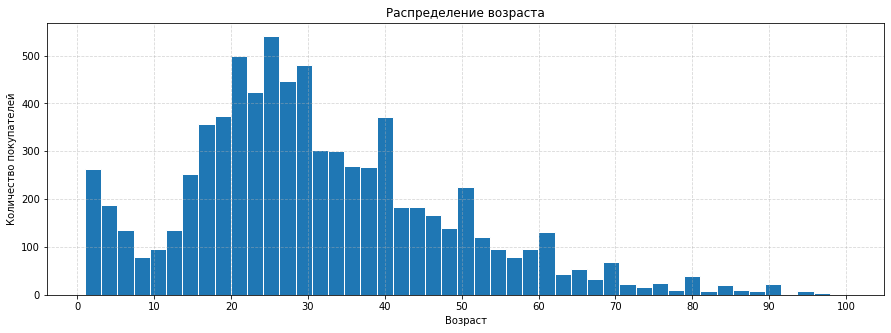

In [4]:
#Строим график
plt.figure(figsize=(15, 5))
plt.hist(df['real_age'], bins='auto', edgecolor='w')
plt.xticks(range(0, max(df['real_age']) + 10, 10))
plt.xlabel('Возраст')
plt.ylabel('Количество покупателей')
plt.title('Распределение возраста')
plt.grid(ls='dashed', alpha=0.5)
plt.show()

Распределение возраста выглядит следующим образом:
- больше всего людей находятся в диапазоне 20-30 лет с пиками в 25, 20 и 30 лет (от большего к меньшему)
- меньше всего в диапазоне от 62 лет и старше и от 9 до 11 лет

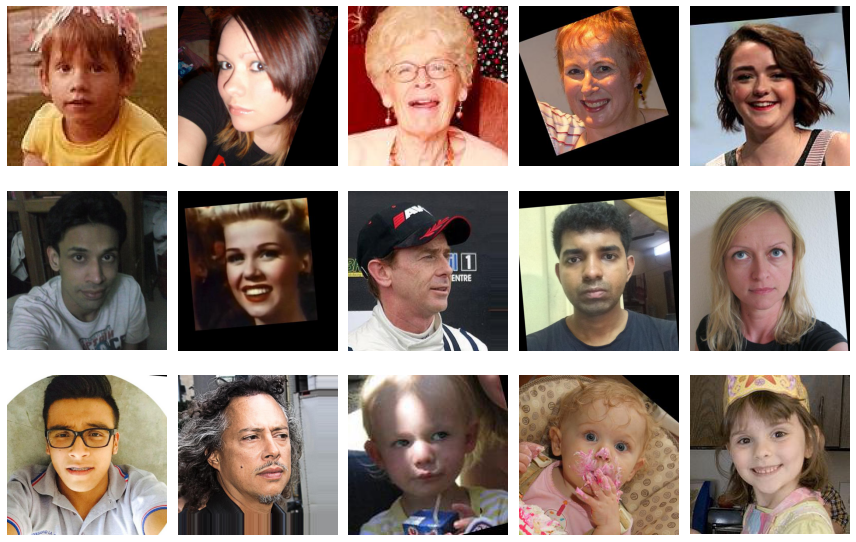

In [5]:
#Напечатаем 15 фотографий
image_files = list(df['file_name'].head(15))

plt.figure(figsize=(12, 8))

for i, image_file in enumerate(image_files):
    path = f'/datasets/faces/final_files/{image_file}'
    image = Image.open(path)
    
    plt.subplot(3, 5, i+1)
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout()
plt.show()

**Вывод:**

- на обучение модели может повлиять недостаточное количество фотографий пожилых людей и детей около 10 лет по сравнению, например, с людьми в диапазоне от 15 до 50 лет. Модель хуже всего обучится на пожилых и детях около 10 лет и будет чаще ошибаться именно на этих возрастах
- также на графике заметны пики по каждому десятилетию, что может говорить о не лучшем качестве данных (могли указывать примерный возраст вместо точного, округляя до кратного 10), это также может сказаться на качестве модели
- достаточно много фотографий принадлежат младенцам или очень маленьким детям, которых точно не будет среди клиентов магазина, что также не добавит очков в пользу модели
- черно-белые фото, посторонние предметы, плохая видимость лица человека, артефакты на фотографиях, повороты и другие преобразования также усложнят работу модели, а вот лица крупным планом наоборот упростят.
- мы используем только горизонтальный флип, а могли бы все аугментации, которым нас обучили в теории: вертикальный и горизонтальный флипы, повороты, а также смещения по осям x и y

## Обучение модели

Ниже указан код обучения модели и результат вывода.

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd

def load_train(path):
    df = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.,
        horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='training',
        class_mode='raw',
        seed=12345)
    return train_datagen_flow

def load_test(path):
    df = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=df,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='validation',
        class_mode='raw',
        seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
  
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data) 

    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,
              batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True)
    return model

```

```

Epoch 1/10
2023-07-17 14:16:08.965420: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-07-17 14:16:09.425321: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 62s - loss: 226.3835 - mae: 10.7290 - val_loss: 844.5090 - val_mae: 24.1715
Epoch 2/10
178/178 - 49s - loss: 73.1214 - mae: 6.4763 - val_loss: 677.0078 - val_mae: 20.9181
Epoch 3/10
178/178 - 47s - loss: 47.3335 - mae: 5.2717 - val_loss: 270.9506 - val_mae: 12.3015
Epoch 4/10
178/178 - 49s - loss: 34.3899 - mae: 4.4671 - val_loss: 109.0998 - val_mae: 7.8430
Epoch 5/10
178/178 - 48s - loss: 26.8813 - mae: 3.9276 - val_loss: 92.1239 - val_mae: 7.3522
Epoch 6/10
178/178 - 47s - loss: 21.5050 - mae: 3.5658 - val_loss: 74.2884 - val_mae: 6.5199
Epoch 7/10
178/178 - 49s - loss: 16.5933 - mae: 3.1125 - val_loss: 87.1279 - val_mae: 7.0646
Epoch 8/10
178/178 - 50s - loss: 14.5826 - mae: 2.9070 - val_loss: 91.6086 - val_mae: 7.1801
Epoch 9/10
178/178 - 53s - loss: 12.4218 - mae: 2.6814 - val_loss: 62.4784 - val_mae: 5.9051
Epoch 10/10
178/178 - 53s - loss: 10.5889 - mae: 2.4697 - val_loss: 64.4056 - val_mae: 6.0402
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 64.4056 - mae: 6.0402
Test MAE: 6.0402

```

## Анализ обученной модели

**Вывод:**

- Мы обучили модель на основе архитектуры ResNet50 (backbone) и двух дополнительных слоев (head) с предобученными весами 'imagenet'
- параметры обучения следующие: размер батча - 32 (в обучении было сказано, что чем больше, тем лучше обучается модель), оптимизатор - Adam с learning rate 0.0001, заморозку весов бэкбона не использовали, поскольку наш датасет достаточно объемный, чтобы этого не делать (заморозка нужна для небольших датасетов), количество эпох - 10 (если будет мало - недообучится, если много - переобучится)
- наша модель может применяться в массе других задач, помимо нашей: определение возраста пациентов в лечебных учреждениях, определение возраста в системах безопасности для предотвращения попыток обмана возрастных ограничений, в целях таргетированной рекламы для клиентов определенных возрастных групп и т.п. 

Поставленная задача с получением MAE на тестовой выборке ниже 8 выполнена, явного переобучения не наблюдалось.

Итоговый результат MAE на тестовой выборке — 6.0402